In [82]:
## Bring in packages
import pandas as pd
import numpy as np
import os
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.ticker as ticker


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score

import scipy.stats as stats
import re
import shap
import seaborn as sns

from importlib import reload

## Change some settings
pd.set_option('display.max_columns', None)

In [4]:
os.chdir('/Users/abrahambaldenegro/Documents/House Prediction Model/pythonProject')
import ab
reload(ab)

ab.abe_says_hi()

abraham is very happy


In [6]:
## Set working directory
os.chdir('/Users/abrahambaldenegro/Documents/House Prediction Model')

RawData = pd.read_csv('/Users/abrahambaldenegro/Documents/House Prediction Model/apartments_for_rent_classified_100K.csv',
                     sep=";", encoding='cp1252', low_memory=False)

display(RawData.head(2))

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, R...",NaN,1.0,1.0,USD,No,Thumbnail,Cats,2195.0,"$2,195",Monthly,542,507 509 Esplanade,Redondo Beach,CA,33.8520,-118.3759,RentLingo,1577360355
1,5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Ne...",NaN,1.5,3.0,USD,No,Thumbnail,"Cats,Dogs",1250.0,"$1,250",Monthly,1500,146 Lochview Dr,Newport News,VA,37.0867,-76.4941,RentLingo,1577360340


In [8]:
## Let's do some cleaning
RawData = ab.clean_data(df=RawData)

Rows before cleaning: 99492
Rows after cleaning: 83022


In [10]:
## Add distance to nearest city
RawData = ab.get_city_features(df=RawData)

In [12]:
## Set up Other Features
RawData = ab.set_up_features(df=RawData)

/Users/abrahambaldenegro/Documents/House Prediction Model/pythonProject/ab/__init__.py:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


In [14]:
## Get Feature Names
all_columns = RawData.columns

feature_vars = ['bathrooms', 'bedrooms',
                'square_feet', 'body_length',
                'amenities_parking', 'amenities_gym', 'amenities_pool',
                'amenities_washer', 'photo_thumbnail', 
                'pets_dogs', 'pets_cat', 'distance_to_closest_city'] + [text for text in all_columns if re.search('^city_', text)] + [text for text in all_columns if re.search('^state_', text)]

prediction_var = "price"

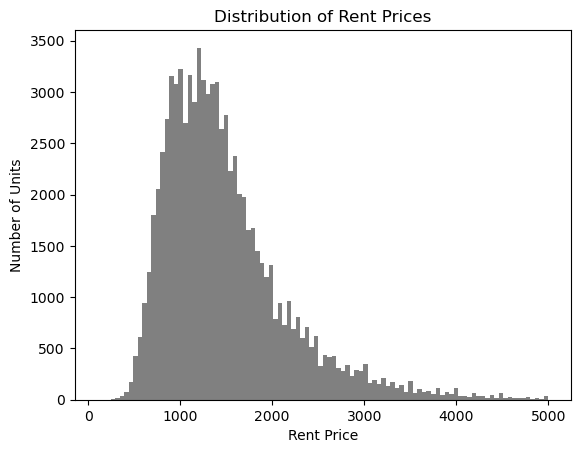

In [16]:
## Let's do some explorations
plt.hist(RawData['price'], bins = 100, color="grey")
plt.ylabel("Number of Units")
plt.xlabel("Rent Price")
plt.title("Distribution of Rent Prices")
plt.show()

In [18]:
## Check distribution of Prices
display(RawData['price'].quantile([0.2, 0.40, .60, 0.80]))

0.2     950.0
0.4    1211.0
0.6    1485.0
0.8    1905.0
Name: price, dtype: float64

In [20]:
## Create buckets of prices
RawData = ab.create_price_bins(df=RawData)

price_cat
01 - Very Low Price (<$1K)            20028
03 - Medium Price ($1.2K to $1.5K)    18531
04 - High Price ($1.5K to $2K)        17925
02 - Low Price ($1K to $1.2K)         12164
05 - Very High Price ($2K to $3K)     11243
06 - Highly Premium ($3K+)             3131
Name: count, dtype: int64

In [22]:
display(RawData)

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_display,price_type,square_feet,address,cityname,latitude,longitude,source,time,distance_to_closest_city,city_albuquerque,city_anaheim,city_anchorage,city_arlington,city_atlanta,city_aurora,city_austin,city_bakersfield,city_baltimore,city_boise,city_boston,city_buffalo,city_chandler,city_charlotte,city_chesapeake,city_chicago,city_chula_vista,city_cincinnati,city_cleveland,city_colorado_springs,city_columbus,city_corpus_christi,city_dallas,city_denver,city_detroit,city_durham,city_el_paso,city_enterprise,city_fort_wayne,city_fort_worth,city_fremont,city_fresno,city_garland,city_gilbert,city_glendale,city_greensboro,city_henderson,city_honolulu,city_houston,city_indianapolis,city_irvine,city_jacksonville,city_jersey_city,city_kansas_city,city_laredo,city_las_vegas,city_lexington,city_lincoln,city_long_beach,city_los_angeles,city_louisville,city_lubbock,city_madison,city_memphis,city_mesa,city_miami,city_milwaukee,city_minneapolis,city_nashville,city_new_orleans,city_new_york_city,city_newark,city_norfolk,city_north_las_vegas,city_oakland,city_oklahoma_city,city_omaha,city_orlando,city_philadelphia,city_phoenix,city_pittsburgh,city_plano,city_portland,city_raleigh,city_reno,city_riverside,city_sacramento,city_san_antonio,city_san_diego,city_san_francisco,city_san_jose,city_santa_ana,city_santa_clarita,city_scottsdale,city_seattle,city_st_louis,city_st_paul,city_st_petersburg,city_stockton,city_tampa,city_toledo,city_tucson,city_tulsa,city_virginia_beach,city_washington_dc,city_wichita,city_winston-salem,body_length,amenities_parking,amenities_gym,amenities_pool,amenities_washer,photo_thumbnail,pets_dogs,pets_cat,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,price_cat
21,5668632369,housing/rent/apartment,One BR 7011 W PARMER LN,"This unit is located at 7011 W PARMER LN, Aust...","Fireplace,Gym,Parking,Pool,Storage,Wood Floors",1.0,1.0,USD,No,Thumbnail,0,1060.0,"$1,060",Monthly,650,7011 W Parmer Lane,Austin,30.3054,-97.7497,RentLingo,1577359827,0.004610,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,02 - Low Price ($1K to $1.2K)
22,5668632002,housing/rent/apartment,One BR 2800 SUNRISE RD,"This unit is located at 2800 SUNRISE RD, Round...","Gated,Pool",1.0,1.0,USD,No,Thumbnail,0,1003.0,"$1,003",Monthly,797,2800 Sunrise Road,Round Rock,30.5118,-97.6873,RentLingo,1577359796,0.211316,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,156,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,02 - Low Price ($1K to $1.2K)
23,5668631854,housing/rent/apartment,One BR 12330 METRIC BLVD.,"This unit is located at 12330 METRIC BLVD., Au...","Dishwasher,Parking,Pool",1.0,1.0,USD,No,Thumbnail,0,837.0,$837,Monthly,444,12330 Metric Boulevard,Austin,30.3054,-97.7497,RentLingo,1577359784,0.004610,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [24]:
with pd.option_context("display.max_rows", 1000):
    display(RawData[['price_cat'] + feature_vars].groupby('price_cat').mean().apply(lambda s: s.apply('{0:.3f}'.format)).T)

price_cat,01 - Very Low Price (<$1K),02 - Low Price ($1K to $1.2K),03 - Medium Price ($1.2K to $1.5K),04 - High Price ($1.5K to $2K),05 - Very High Price ($2K to $3K),06 - Highly Premium ($3K+)
bathrooms,1.212,1.373,1.461,1.534,1.600,1.841
bedrooms,1.494,1.599,1.727,1.821,1.885,2.119
square_feet,791.360,889.417,952.202,1010.457,1072.055,1253.416
body_length,789.200,854.337,874.435,860.412,857.245,814.712
amenities_parking,0.476,0.508,0.542,0.563,0.547,0.519
amenities_gym,0.372,0.493,0.473,0.470,0.466,0.406
amenities_pool,0.496,0.570,0.544,0.531,0.483,0.439
amenities_washer,0.476,0.449,0.398,0.343,0.342,0.364
photo_thumbnail,0.376,0.347,0.348,0.329,0.274,0.225
pets_dogs,0.387,0.447,0.407,0.365,0.334,0.293


In [40]:
RawData[['price_cat'] + feature_vars].describe().style.format("{:,.2f}")

,bathrooms,bedrooms,square_feet,body_length,amenities_parking,amenities_gym,amenities_pool,amenities_washer,photo_thumbnail,pets_dogs,pets_cat,distance_to_closest_city,city_albuquerque,city_anaheim,city_anchorage,city_arlington,city_atlanta,city_aurora,city_austin,city_bakersfield,city_baltimore,city_boise,city_boston,city_buffalo,city_chandler,city_charlotte,city_chesapeake,city_chicago,city_chula_vista,city_cincinnati,city_cleveland,city_colorado_springs,city_columbus,city_corpus_christi,city_dallas,city_denver,city_detroit,city_durham,city_el_paso,city_enterprise,city_fort_wayne,city_fort_worth,city_fremont,city_fresno,city_garland,city_gilbert,city_glendale,city_greensboro,city_henderson,city_honolulu,city_houston,city_indianapolis,city_irvine,city_jacksonville,city_jersey_city,city_kansas_city,city_laredo,city_las_vegas,city_lexington,city_lincoln,city_long_beach,city_los_angeles,city_louisville,city_lubbock,city_madison,city_memphis,city_mesa,city_miami,city_milwaukee,city_minneapolis,city_nashville,city_new_orleans,city_new_york_city,city_newark,city_norfolk,city_north_las_vegas,city_oakland,city_oklahoma_city,city_omaha,city_orlando,city_philadelphia,city_phoenix,city_pittsburgh,city_plano,city_portland,city_raleigh,city_reno,city_riverside,city_sacramento,city_san_antonio,city_san_diego,city_san_francisco,city_san_jose,city_santa_ana,city_santa_clarita,city_scottsdale,city_seattle,city_st_louis,city_st_paul,city_st_petersburg,city_stockton,city_tampa,city_toledo,city_tucson,city_tulsa,city_virginia_beach,city_washington_dc,city_wichita,city_winston-salem,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
count,"83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00","83,022.00"
mean,1.44,1.71,944.37,843

In [50]:
## Set up data for model

## Data Processing ##
X = RawData[feature_vars]
y = RawData['price']

print(f"The average price is ${np.mean(y):,.2f}")

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 97)

The average price is $1,484.98


In [72]:
## Set up table for XGBOOST ##
xgDMatrix = xgb.DMatrix(X_train, y_train)
xgbDMatrixTrain = xgb.DMatrix(X_train, y_train)
xgbDMatrixTest = xgb.DMatrix(X_test, y_test)

eval_set = [(xgbDMatrixTest, 'Test'), (xgDMatrix, 'Train')]
evals_result_base = {}

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 15,
    'learning_rate':0.15
}

In [145]:
base_model = xgb.train(params = params,
                       dtrain = xgDMatrix,
                       num_boost_round=1000,
                       evals=eval_set,
                       obj=None,
                       evals_result=evals_result_base,
                       verbose_eval=100)

[0]	Test-rmse:599.54383	Train-rmse:597.58408
[100]	Test-rmse:268.40994	Train-rmse:118.36299
[200]	Test-rmse:261.15226	Train-rmse:72.54405
[300]	Test-rmse:258.99567	Train-rmse:45.29902
[400]	Test-rmse:258.29905	Train-rmse:29.20935
[500]	Test-rmse:258.14759	Train-rmse:21.95080
[600]	Test-rmse:258.11782	Train-rmse:17.14202
[700]	Test-rmse:258.11993	Train-rmse:14.74212
[800]	Test-rmse:258.12291	Train-rmse:13.58315
[900]	Test-rmse:258.14040	Train-rmse:12.99460
[999]	Test-rmse:258.14983	Train-rmse:12.74154


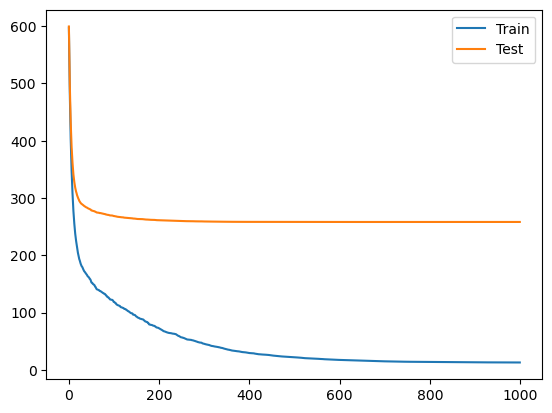

In [147]:
# plot learning curves
pyplot.plot(evals_result_base['Train']['rmse'], label='Train')
pyplot.plot(evals_result_base['Test']['rmse'], label='Test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

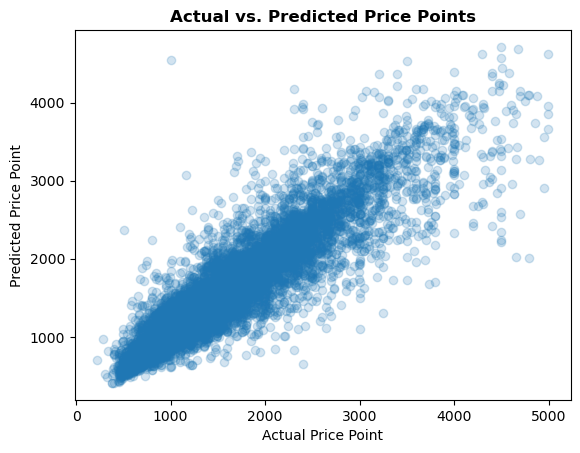

In [116]:
## Check if predictions align with actual (on the test set)
pred_y = base_model.predict(xgbDMatrixTest)

plt.scatter(x = y_test, y = pred_y, alpha=0.2)
plt.title('Actual vs. Predicted Price Points', weight='bold')
plt.xlabel('Actual Price Point')
plt.ylabel('Predicted Price Point')
plt.show()

In [163]:
################
## Tune model ##
################

# Define the hyperparameter distributions
param_dist = {
     'learning_rate' : [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40],
     'max_depth' : [5, 6, 10, 12, 15, 20, 25, 40, 60],
     'min_child_weight' : [1, 3, 5, 7],
     'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
     'colsample_bytree' : [0.3, 0.4, 0.5, 0.7],
     'n_estimators': [20,50,100,200,500,1000]
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions=param_dist, 
                                   n_iter=200, 
                                   cv=3, 
                                   scoring='neg_root_mean_squared_error',
                                   verbose = 3)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
best_hyperparameters = random_search.best_params_
best_score = random_search.best_score_

print("Best set of hyperparameters: ", best_hyperparameters)
print("Best score: ", best_score)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV 1/3] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=50;, score=-317.479 total time=   0.2s
[CV 2/3] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=50;, score=-324.453 total time=   0.2s
[CV 3/3] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=50;, score=-328.559 total time=   0.2s
[CV 1/3] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.2, max_depth=60, min_child_weight=1, n_estimators=20;, score=-288.298 total time=   1.7s
[CV 2/3] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.2, max_depth=60, min_child_weight=1, n_estimators=20;, score=-298.572 total time=   1.7s
[CV 3/3] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.2, max_depth=60, min_child_weight=1, n_estimators=20;, score=-292.426 total time=   1.7s
[CV 1/3] END colsample_bytree=0.3,

In [185]:
## Need to tweak one parameter
evals_result_optimized = {}

try:
    opt_num_rounds = best_hyperparameters['n_estimators']
    del best_hyperparameters['n_estimators']
except:
    None

model_optimized = xgb.train(params = best_hyperparameters,
                            dtrain = xgDMatrix,
                            evals=eval_set,
                            num_boost_round=opt_num_rounds,
                            obj=None,
                            evals_result=evals_result_optimized,
                            verbose_eval=100)

[0]	Test-rmse:653.67483	Train-rmse:656.49333
[100]	Test-rmse:306.64647	Train-rmse:250.83821
[200]	Test-rmse:277.12480	Train-rmse:197.64397
[300]	Test-rmse:267.79547	Train-rmse:176.72533
[400]	Test-rmse:261.87312	Train-rmse:162.62019
[500]	Test-rmse:258.33128	Train-rmse:152.01816
[600]	Test-rmse:255.66722	Train-rmse:142.31679
[700]	Test-rmse:253.25533	Train-rmse:132.83934
[800]	Test-rmse:251.05567	Train-rmse:123.52697
[900]	Test-rmse:249.75273	Train-rmse:116.59335
[999]	Test-rmse:248.20798	Train-rmse:108.63782


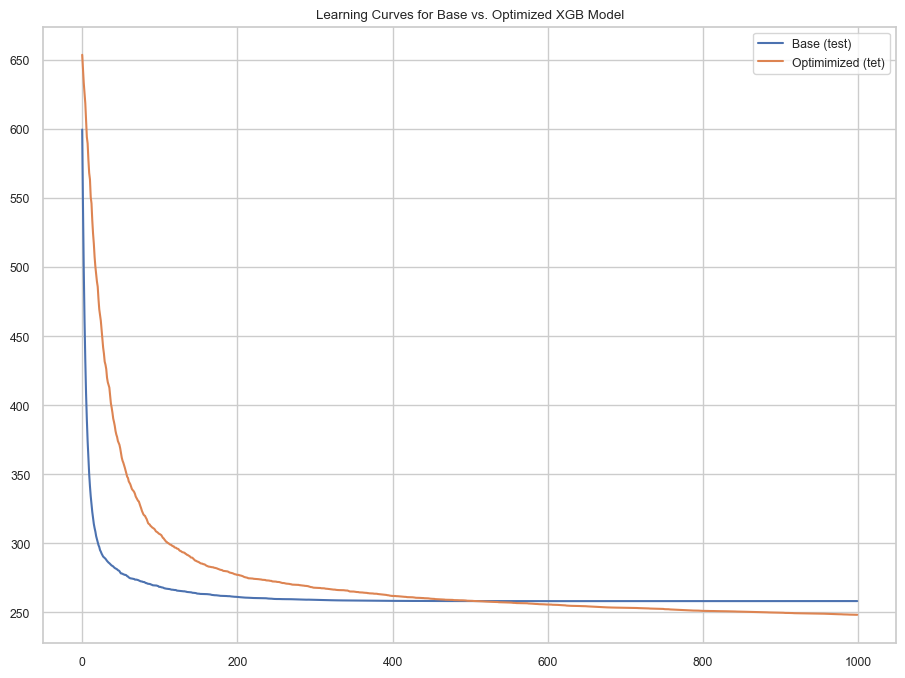

In [183]:
## Let's see how the optimized model compares to the base model
pyplot.plot(evals_result_base['Test']['rmse'], label='Base (test)')
pyplot.plot(evals_result_optimized['Test']['rmse'], label='Optimimized (tet)')

pyplot.title('Learning Curves for Base vs. Optimized XGB Model')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

100%|===================| 9997/10000 [06:37<00:00]        

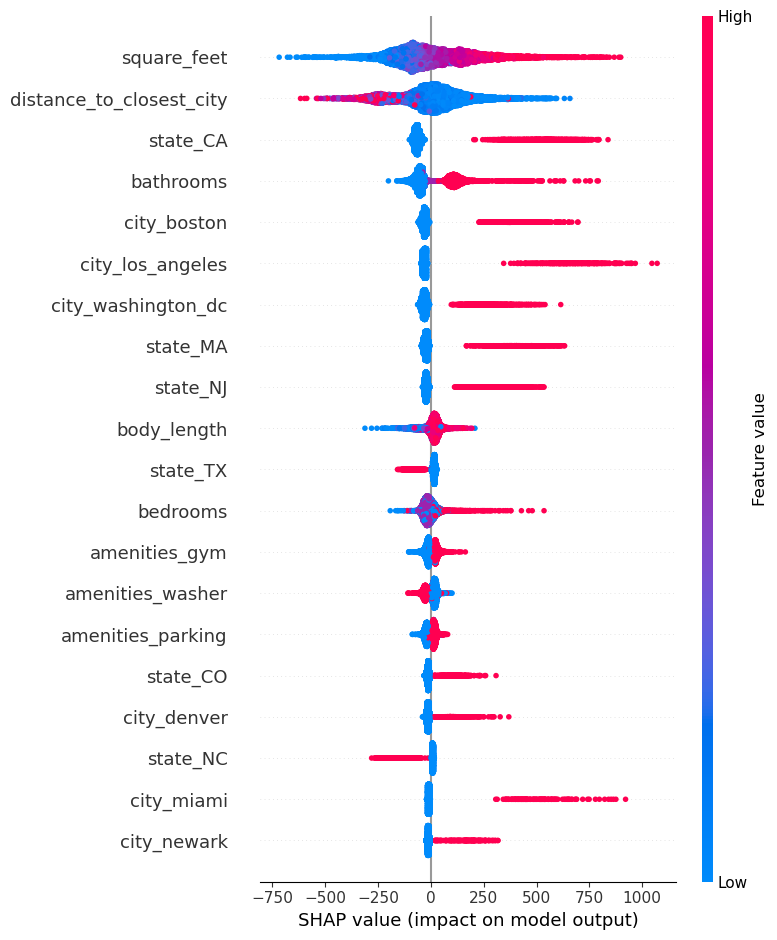

In [174]:
##########
## Shap ##
##########

sample_x_test = X_test.sample(10000)
explainer = shap.Explainer(model_optimized, sample_x_test)

# Calculate SHAP values
shap_values = explainer(sample_x_test)

# Visualize the SHAP values (optional)
shap.summary_plot(shap_values, sample_x_test)

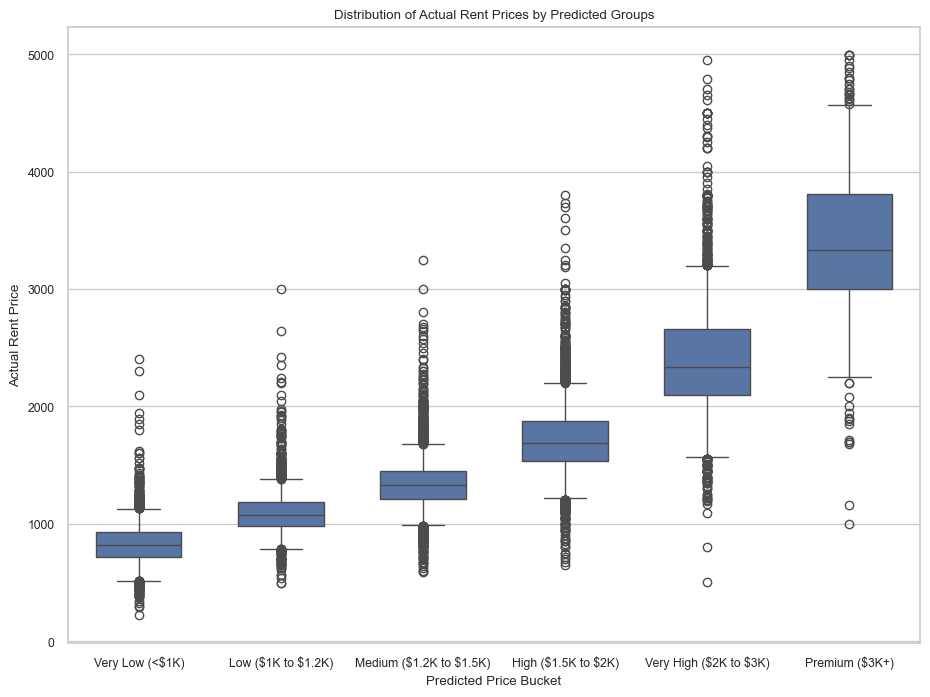

In [176]:
new_category_names = [
                    'Very Low (<$1K)',
                    'Low (\\$1K to \\$1.2K)',
                    'Medium (\\$1.2K to \\$1.5K)',
                    'High (\\$1.5K to \\$2K)',
                    'Very High (\\$2K to \\$3K)',
                    'Premium (\\$3K+)'
                   ]

## Boxplot
predicted_price = pd.DataFrame({'price_actual':y_test,
                                'price':pred_y})

predicted_price = ab.create_price_bins(df=predicted_price, print_results=False, category_names=new_category_names)

predicted_price.rename(columns={'price_cat': 'Predicted Price Category'}, inplace=True)


sns.set(rc={'figure.figsize':(11,8)}, font_scale=0.8, style='whitegrid')
sns.boxplot(data=predicted_price, 
            x='Predicted Price Category', 
            y='price_actual',
            order = new_category_names,
            width=0.6,
            whis=0.95).set(
    xlabel='Predicted Price Bucket', 
    ylabel='Actual Rent Price'
)
plt.title('Distribution of Actual Rent Prices by Predicted Groups')
plt.show()

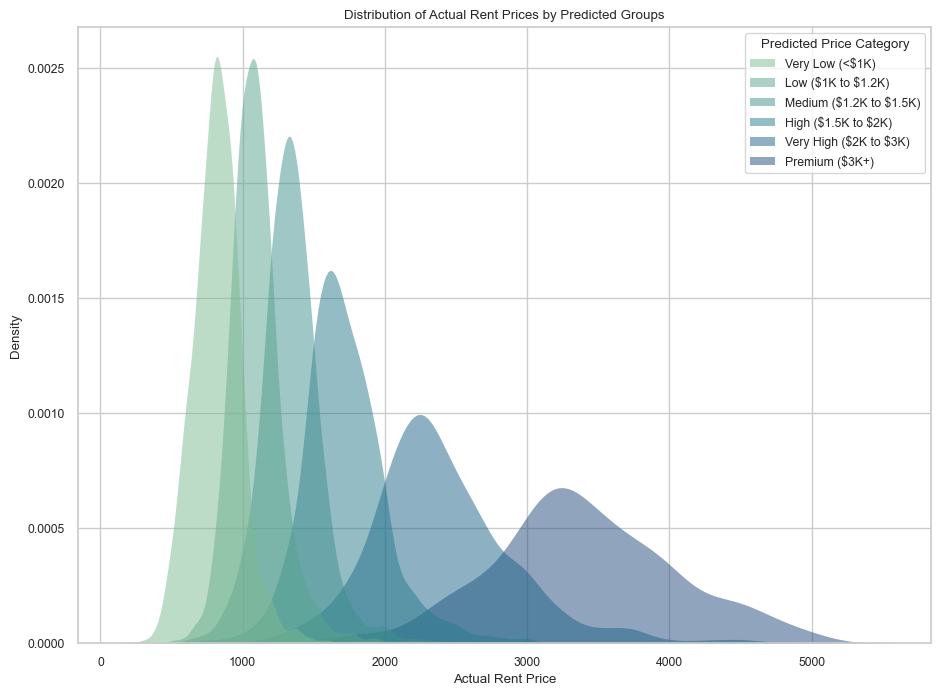

In [178]:
sns.kdeplot(
   data=predicted_price, x="price_actual", hue='Predicted Price Category',
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0, hue_order=new_category_names).set(
    xlabel='Actual Rent Price', 
)
plt.title('Distribution of Actual Rent Prices by Predicted Groups')
plt.show()

In [187]:
print("hello")

hello
